## Load necessary modules

In [1]:
# show images inline
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet.models.resnet import custom_objects
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

import shutil
from multiprocessing import Pool
import multiprocessing

# set tf backend to allow memory to grow, instead of claiming everything
import tensorflow as tf

def get_session():
    config = tf.ConfigProto(log_device_placement=True)
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

# use this environment flag to change which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# set the modified tf session as backend in keras
keras.backend.tensorflow_backend.set_session(get_session())

/home/poddiachyi/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Load RetinaNet model

In [2]:
# adjust this to point to your downloaded/trained model
# models can be downloaded here: https://github.com/fizyr/keras-retinanet/releases
model_path = os.path.join('..', 'snapshots', 'resnet50_coco_best_v2.0.3.h5')

# load retinanet model
model = keras.models.load_model(model_path, custom_objects=custom_objects)
#print(model.summary())

# load label to names mapping for visualization purposes
labels_to_names = {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 
                   5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 
                   10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 
                   14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 
                   20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 
                   25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 
                   30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 
                   35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 
                   39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 
                   45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 
                   51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 
                   57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 
                   62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 
                   68: 'microwave', 69: 'oven', 70: 'toaster', 71: 'sink', 72: 'refrigerator', 
                   73: 'book', 74: 'clock', 75: 'vase', 76: 'scissors', 77: 'teddy bear', 
                   78: 'hair drier', 79: 'toothbrush'}

/home/poddiachyi/anaconda3/lib/python3.6/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


## Run detection on example

processing time:  0.19339275360107422
2.1333333333333333
[162  67 455 371]


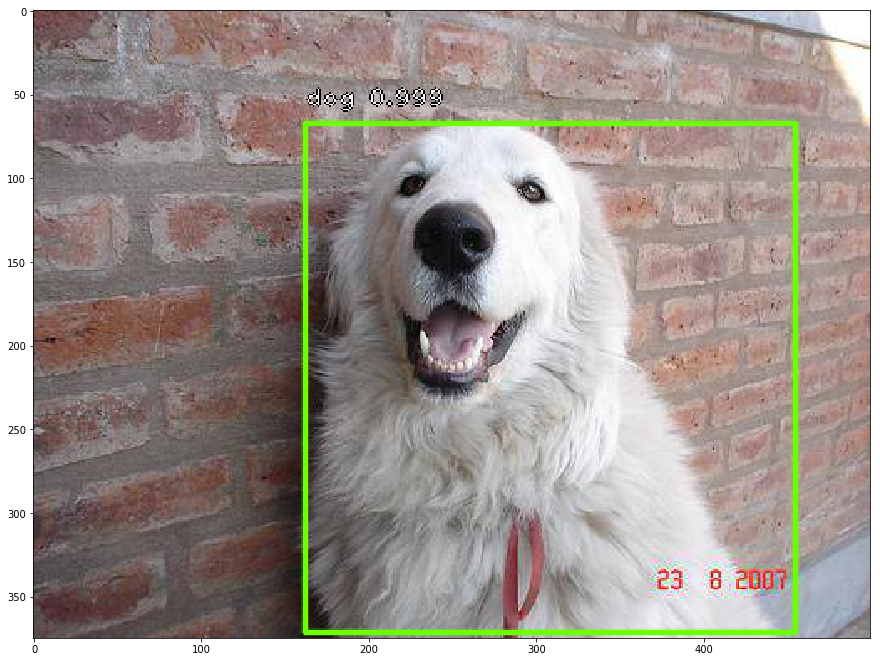

In [8]:
# load image
image = read_image_bgr('dog1.jpg')

# copy to draw on
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

# preprocess image for network
image = preprocess_image(image)
image, scale = resize_image(image)

# process image
start = time.time()
boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
print("processing time: ", time.time() - start)

print(scale)
# correct for image scale
boxes /= scale

# print(labels)
# visualize detections
for box, score, label in zip(boxes[0], scores[0], labels[0]):
    # scores are sorted so we can break
    if score < 0.5:
        break
        
    
    color = label_color(label)
#     print(box, label)
    b = box.astype(int)
    print(b)
    draw_box(draw, b, color=color)
    
    caption = "{} {:.3f}".format(labels_to_names[label], score)
    draw_caption(draw, b, caption)
    
plt.figure(figsize=(15, 15))
# plt.axis('off')
plt.imshow(draw)
plt.show()

In [5]:
dir_name = 'train_renamed/'
no_dogs = 'no_dog_found/'
file_names = os.listdir(dir_name)
len_file_names = len(file_names)

In [60]:
# pool = Pool(8)
# pool.map(mark_image, file_names)
# pool.close()
# pool.join()

In [50]:
def mark_image(file_name):
    only_name = file_name.split('.')[0]
    
    breed_label = only_name.split('_')[0]
    
    file_path = os.path.join(dir_name, file_name)
    image = read_image_bgr(file_path)

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    # correct for image scale
    boxes /= scale
    
    dog_found = False 

    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        
        # scores are sorted so we can break
        if score < 0.5:
            break
        
        if label == 16:
            dog_found = True
            b = box.astype(int)
            
            with open('annotations/{}.txt'.format(only_name), 'w') as f:
                to_write = ' '.join([str(item) for item in b])
                f.write(str(breed_label) + '\n')
                f.write(to_write)

    if not dog_found:
        shutil.copy(file_path, no_dogs)

In [6]:
%%time
counter = 0
for file_name in file_names:
    
    only_name = file_name.split('.')[0]
    
    breed_label = only_name.split('_')[0]
    
    file_path = os.path.join(dir_name, file_name)
    image = read_image_bgr(file_path)

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    # correct for image scale
    boxes /= scale
    
    dog_found = False 

    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        
        # scores are sorted so we can break
        if score < 0.5:
            break
        
        if label == 16:
            dog_found = True
            b = box.astype(int)
            
            with open('annotations/{}.txt'.format(only_name), 'w') as f:
                to_write = ' '.join([str(item) for item in b])
                f.write(str(breed_label) + '\n')
                f.write(to_write)
                
        


    if not dog_found:
        shutil.copy(file_path, no_dogs)
        

    counter += 1
    
    if counter % 100 == 0:
        print('{} / {}'.format(counter, len_file_names))
                 

100 / 10222
200 / 10222
300 / 10222
400 / 10222
500 / 10222
600 / 10222
700 / 10222
800 / 10222
900 / 10222
1000 / 10222
1100 / 10222
1200 / 10222
1300 / 10222
1400 / 10222
1500 / 10222
1600 / 10222
1700 / 10222
1800 / 10222
1900 / 10222
2000 / 10222
2100 / 10222
2200 / 10222
2300 / 10222
2400 / 10222
2500 / 10222
2600 / 10222
2700 / 10222
2800 / 10222
2900 / 10222
3000 / 10222
3100 / 10222
3200 / 10222
3300 / 10222
3400 / 10222
3500 / 10222
3600 / 10222
3700 / 10222
3800 / 10222
3900 / 10222
4000 / 10222
4100 / 10222
4200 / 10222
4300 / 10222
4400 / 10222
4500 / 10222
4600 / 10222
4700 / 10222
4800 / 10222
4900 / 10222
5000 / 10222
5100 / 10222
5200 / 10222
5300 / 10222
5400 / 10222
5500 / 10222
5600 / 10222
5700 / 10222
5800 / 10222
5900 / 10222
6000 / 10222
6100 / 10222
6200 / 10222
6300 / 10222
6400 / 10222
6500 / 10222
6600 / 10222
6700 / 10222
6800 / 10222
6900 / 10222
7000 / 10222
7100 / 10222
7200 / 10222
7300 / 10222
7400 / 10222
7500 / 10222
7600 / 10222
7700 / 10222
7800 / 1